January 27, 2026

##### Model 4 Changes (from Model 3):

**Critical Bug Fix:**
- Fixed patient indexing bug in dataset that caused 12% of validation samples to fail

**New Features:**
- Multi-class segmentation (4 classes: Background, NCR/NET, Edema, Enhancing Tumor)
- Includes slices WITHOUT tumors (model learns when there's no tumor)
- Data augmentation: rotation (±15°) and horizontal flip
- Multi-class Dice Loss with per-class tracking
- Modified U-Net to support variable number of output classes

**Still Using:**
- Single modality (T1ce only) - Multi-modality will be Model 5
- 2D slices - 3D model will be Model 6

# The Data Pipeline: 3D .nii file -> 2D image -> torch tensors

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# NEW FOR MODEL 4: Import the new multi-class dataset
from brats_utils import BraTSFastDataset  # *** FIX ***: Using fast dataset

# *** FIX ***: Now using preprocessed data (run preprocess_to_npy.py first!)
PREPROCESSED_DIR = Path("/home/sagemaker-user/brats-preprocessed")

# *** FIX ***: Using BraTSFastDataset which loads from .npy files (10-50x faster)
train_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='train', augment=True)
validation_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='val', augment=False)
test_dataset = BraTSFastDataset(PREPROCESSED_DIR, split='test', augment=False)

Loaded train dataset: 26156 slices
  → 13241 with tumor (50.6%)
  → 12915 without tumor
Loaded val dataset: 13051 slices
  → 6545 with tumor (50.1%)
  → 6506 without tumor
Loaded test dataset: 8766 slices
  → 4515 with tumor (51.5%)
  → 4251 without tumor


##### Quick Data Visualization

Image Shape: torch.Size([1, 240, 240])
Mask Shape: torch.Size([240, 240])
Mask dtype: torch.int64
Unique labels in mask: tensor([0, 1, 2, 3])


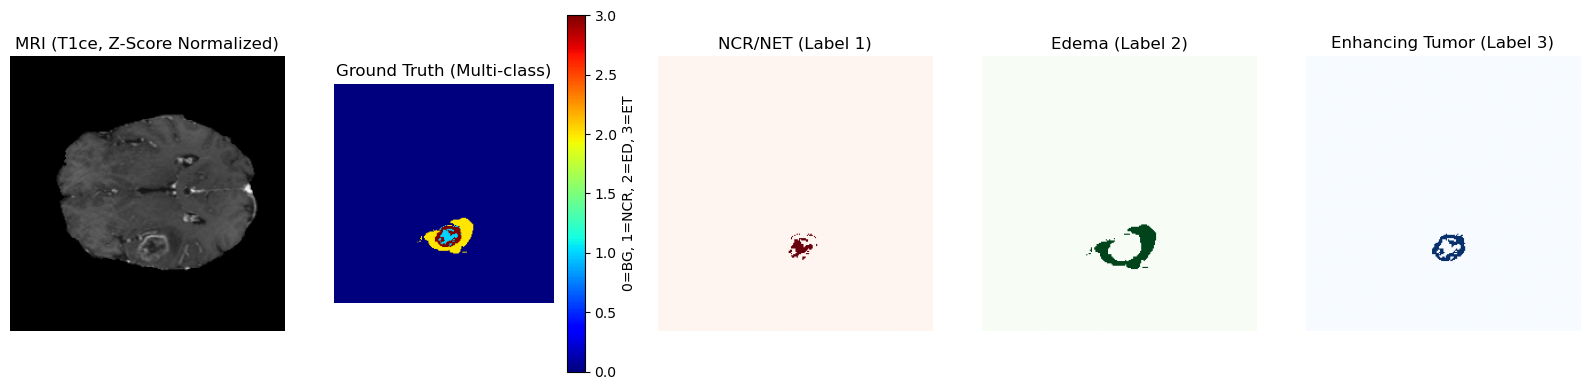

In [3]:
if len(train_dataset) > 0:
    sample_img, sample_mask = train_dataset[1485] 

    print(f"Image Shape: {sample_img.shape}")  # Expect: (1, 240, 240)
    print(f"Mask Shape: {sample_mask.shape}")  # NEW: Expect (240, 240) not (1, 240, 240)
    print(f"Mask dtype: {sample_mask.dtype}")  # NEW: Expect torch.int64 (long) not float
    print(f"Unique labels in mask: {torch.unique(sample_mask)}")  # NEW: Should see 0, 1, 2, 3

    def visualize_multiclass(img_tensor, mask_tensor):
        """NEW FOR MODEL 4: Visualize multi-class mask with different colors"""
        img = img_tensor.squeeze().numpy()
        mask = mask_tensor.numpy()
        
        plt.figure(figsize=(16, 4))
        
        plt.subplot(1, 5, 1)
        plt.imshow(img, cmap='gray')
        plt.title("MRI (T1ce, Z-Score Normalized)")
        plt.axis('off')
        
        plt.subplot(1, 5, 2)
        plt.imshow(mask, cmap='jet', vmin=0, vmax=3)
        plt.title("Ground Truth (Multi-class)")
        plt.colorbar(label="0=BG, 1=NCR, 2=ED, 3=ET")
        plt.axis('off')
        
        # Show each class separately
        plt.subplot(1, 5, 3)
        plt.imshow((mask == 1).astype(float), cmap='Reds')
        plt.title("NCR/NET (Label 1)")
        plt.axis('off')
        
        plt.subplot(1, 5, 4)
        plt.imshow((mask == 2).astype(float), cmap='Greens')
        plt.title("Edema (Label 2)")
        plt.axis('off')
        
        plt.subplot(1, 5, 5)
        plt.imshow((mask == 3).astype(float), cmap='Blues')
        plt.title("Enhancing Tumor (Label 3)")
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()

    visualize_multiclass(sample_img, sample_mask)
else:
    print("ERROR: Dataset is empty. Please check the data path.")

##### The DataLoader

In [4]:
# *** FIX ***: Added WeightedRandomSampler to oversample tumor slices
# *** FIX ***: Added pin_memory=True and persistent_workers for speed

BATCH_SIZE = 32  # *** FIX ***: Increased from 16 (you have GPU memory to spare)

# *** FIX ***: Oversample slices with tumor (5x more likely to be selected)
# This helps the model see more tumor examples during training
sample_weights = train_dataset.get_sample_weights(tumor_oversample_factor=5.0)
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=train_sampler,  # *** FIX ***: Use weighted sampler instead of shuffle
    num_workers=4,
    pin_memory=True,  # *** FIX ***: Faster CPU->GPU transfer
    persistent_workers=True  # *** FIX ***: Keep workers alive between epochs
)

validation_dataloader = DataLoader(
    validation_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True,
    persistent_workers=True
)

batch_imgs, batch_masks = next(iter(train_dataloader))

print(f"Batch of Images Shape: {batch_imgs.shape}")  # (32, 1, 240, 240)
print(f"Batch of Masks Shape:  {batch_masks.shape}")  # (32, 240, 240)

# *** FIX ***: Sanity check - verify mask values are valid
print(f"Unique mask values in batch: {torch.unique(batch_masks).tolist()}")
assert all(v in [0, 1, 2, 3] for v in torch.unique(batch_masks).tolist()), "Invalid mask values!"
print("✓ Mask values OK")

Batch of Images Shape: torch.Size([32, 1, 240, 240])
Batch of Masks Shape:  torch.Size([32, 240, 240])
Unique mask values in batch: [0, 1, 2, 3]
✓ Mask values OK


# The Model: U-NET (Modified for Multi-Class)

In [5]:
import torch.nn as nn

class SimpleUNet(nn.Module):
    """
    MODIFIED FOR MODEL 4: Added num_classes parameter
    
    Now supports multi-class output by changing the final convolutional layer
    to output num_classes channels instead of always outputting 1.
    """
    def __init__(self, num_classes=1):  # NEW: num_classes parameter (default=1 for backward compatibility)
        super().__init__()
        
        # Encoder (same as Model 3)
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.Conv2d(16, 16, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2, 2) # 240 -> 120
        
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.Conv2d(32, 32, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool2d(2, 2) # 120 -> 60
        
        self.enc3 = nn.Sequential(nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool3 = nn.MaxPool2d(2, 2) # 60 -> 30

        # Bottleneck (same as Model 3)
        self.bottleneck = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())

        # Decoder (same as Model 3)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec3 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU()) 

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2) 
        self.dec2 = nn.Sequential(nn.Conv2d(64, 32, 3, padding=1), nn.ReLU()) 

        self.up1 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2) 
        self.dec1 = nn.Sequential(nn.Conv2d(32, 16, 3, padding=1), nn.ReLU()) 

        # NEW FOR MODEL 4: Final layer now outputs num_classes channels instead of 1
        self.final = nn.Conv2d(16, num_classes, kernel_size=1)
        
        # NEW FOR MODEL 4: No sigmoid! For multi-class we'll use softmax (applied in loss function)
        # (We could add softmax here, but it's more efficient to use it inside the loss)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        
        # Bottleneck
        b = self.bottleneck(self.pool3(e3))
        
        # Decoder with skip connections
        d3 = self.up3(b)
        d3 = torch.cat((e3, d3), dim=1) 
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat((e2, d2), dim=1) 
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((e1, d1), dim=1) 
        d1 = self.dec1(d1)
        
        # NEW FOR MODEL 4: Return logits (no sigmoid/softmax applied)
        return self.final(d1)

##### Quick Shape Check

In [6]:
# NEW FOR MODEL 4: Initialize with num_classes=4
model = SimpleUNet(num_classes=4)

predictions = model(batch_imgs).detach()

print(f"Input Shape:      {batch_imgs.shape}")  # (16, 1, 240, 240)
print(f"Prediction Shape: {predictions.shape}")  # NEW: (16, 4, 240, 240) - 4 classes!
print(f"Mask Shape:       {batch_masks.shape}")  # (16, 240, 240)

# For multi-class, we compare prediction channels to mask classes
print("\nSUCCESS: The model output has 4 channels (one per class). Ready to train!")

Input Shape:      torch.Size([32, 1, 240, 240])
Prediction Shape: torch.Size([32, 4, 240, 240])
Mask Shape:       torch.Size([32, 240, 240])

SUCCESS: The model output has 4 channels (one per class). Ready to train!


##### Set up Device, Loss, and Optimizer

In [7]:
# *** FIX ***: CE + Dice combined loss (fixes the "predict NCR everywhere" problem)
import torch.optim as optim

# Device setup
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✓ Using Apple Metal (MPS) Acceleration!")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ Using NVIDIA CUDA: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("Using CPU (Slower, but works)")

model = model.to(device)

# =============================================================================
# *** FIX ***: CE + Dice Combined Loss
# =============================================================================
# 
# PREVIOUS BUG: Excluding background entirely caused the model to predict
# NCR (class 1) for the entire brain - it had no incentive to predict background.
#
# THE FIX: Use CrossEntropy + Dice combined
# - CE punishes every wrong pixel (handles background)
# - Dice optimizes tumor overlap (what you're scored on)
# =============================================================================

class CombinedLoss(nn.Module):
    """
    CrossEntropy + Dice (standard for medical segmentation)
    """
    def __init__(self, num_classes=4, smooth=1e-6):
        super().__init__()
        self.num_classes = num_classes
        self.smooth = smooth
        
        # CE class weights: low for background, high for tumors
        ce_weights = torch.tensor([0.1, 1.0, 1.0, 1.0])
        self.ce = nn.CrossEntropyLoss(weight=ce_weights)
        
    def forward(self, predictions, targets):
        # Move CE weights to correct device
        self.ce.weight = self.ce.weight.to(predictions.device)
        
        # CrossEntropy loss
        ce_loss = self.ce(predictions, targets)
        
        # Dice loss (on tumor classes only)
        probs = torch.softmax(predictions, dim=1)
        targets_one_hot = torch.zeros_like(probs)
        targets_one_hot.scatter_(1, targets.unsqueeze(1), 1)
        
        dice_scores = []
        for c in range(1, self.num_classes):  # Skip background for Dice
            pred_c = probs[:, c, :, :]
            target_c = targets_one_hot[:, c, :, :]
            
            intersection = torch.sum(pred_c * target_c)
            union = torch.sum(pred_c) + torch.sum(target_c)
            
            dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
            dice_scores.append(dice)
        
        dice_loss = 1.0 - torch.mean(torch.stack(dice_scores))
        
        # Combine 50/50
        return 0.5 * ce_loss + 0.5 * dice_loss

criterion = CombinedLoss(num_classes=4)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print("✓ Loss function: CE + Dice combined")

✓ Using NVIDIA CUDA: Tesla T4
✓ Loss function: CE + Dice combined


# The Training Loop

In [8]:
# *** FIX ***: Added proper model.eval() and torch.no_grad() for validation
# *** FIX ***: compute_dice_per_class now uses argmax for accurate monitoring

from tqdm.auto import tqdm

num_epochs = 10
history = {
    'train_loss': [],
    'val_loss': [],
    'train_dice_per_class': [],
    'val_dice_per_class': []
}

# *** FIX ***: Improved helper function - uses argmax for hard predictions (more accurate monitoring)
def compute_dice_per_class(predictions, targets, num_classes=4, smooth=1e-6):
    """Compute Dice score for each class separately (for monitoring)"""
    with torch.no_grad():
        # *** FIX ***: Use argmax to get hard class predictions (more accurate than soft)
        pred_probs = torch.softmax(predictions, dim=1)
        pred_classes = torch.argmax(pred_probs, dim=1)  # (B, H, W)
        
        dice_scores = []
        for c in range(num_classes):
            pred_c = (pred_classes == c).float()
            target_c = (targets == c).float()
            
            intersection = torch.sum(pred_c * target_c)
            union = torch.sum(pred_c) + torch.sum(target_c)

            dice = (2.0 * intersection + smooth) / (union + smooth)
            dice_scores.append(dice.item())
        
        return dice_scores

print("Starting Training...")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Training samples: {len(train_dataset)}")
print(f"  - Validation samples: {len(validation_dataset)}")
print()

best_val_loss = float('inf')

for epoch in range(num_epochs):
    # ==================== TRAINING ====================
    model.train()
    train_running_loss = 0.0
    train_dice_accumulator = [0.0, 0.0, 0.0, 0.0]
    
    for images, masks in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
        
        # Track per-class Dice
        with torch.no_grad():
            dice_scores = compute_dice_per_class(outputs, masks)
            for c in range(4):
                train_dice_accumulator[c] += dice_scores[c]
    
    train_epoch_loss = train_running_loss / len(train_dataloader)
    train_dice_per_class = [score / len(train_dataloader) for score in train_dice_accumulator]
    history['train_loss'].append(train_epoch_loss)
    history['train_dice_per_class'].append(train_dice_per_class)

    print(f"\nTrain Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Loss: {train_epoch_loss:.4f}")
    print(f"  Dice per class - BG: {train_dice_per_class[0]:.4f}, NCR: {train_dice_per_class[1]:.4f}, ED: {train_dice_per_class[2]:.4f}, ET: {train_dice_per_class[3]:.4f}")

    # ==================== VALIDATION ====================
    model.eval()  # *** FIX ***: Set to eval mode (disables dropout, batchnorm uses running stats)
    validation_running_loss = 0.0
    val_dice_accumulator = [0.0, 0.0, 0.0, 0.0]
    
    with torch.no_grad():  # *** FIX ***: Disable gradient computation for validation
        for images, masks in tqdm(validation_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            validation_running_loss += loss.item()
            
            dice_scores = compute_dice_per_class(outputs, masks)
            for c in range(4):
                val_dice_accumulator[c] += dice_scores[c]
    
    validation_epoch_loss = validation_running_loss / len(validation_dataloader)
    val_dice_per_class = [score / len(validation_dataloader) for score in val_dice_accumulator]
    history['val_loss'].append(validation_epoch_loss)
    history['val_dice_per_class'].append(val_dice_per_class)

    print(f"Val Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Loss: {validation_epoch_loss:.4f}")
    print(f"  Dice per class - BG: {val_dice_per_class[0]:.4f}, NCR: {val_dice_per_class[1]:.4f}, ED: {val_dice_per_class[2]:.4f}, ET: {val_dice_per_class[3]:.4f}")
    
    # *** FIX ***: Save best model based on validation loss
    if validation_epoch_loss < best_val_loss:
        best_val_loss = validation_epoch_loss
        torch.save(model.state_dict(), 'model4_best.pth')
        print(f"  ✓ Saved best model (val_loss={validation_epoch_loss:.4f})")

# Save final model
torch.save(model.state_dict(), 'model4_checkpoint.pth')
print("\n✓ Training complete! Saved model4_checkpoint.pth")

Starting Training...
  - Epochs: 10
  - Batch size: 32
  - Training samples: 26156
  - Validation samples: 13051



Epoch 1/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [1/10]
  Loss: 0.4437
  Dice per class - BG: 0.9861, NCR: 0.4208, ED: 0.3156, ET: 0.5462


Epoch 1/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [1/10]
  Loss: 0.5256
  Dice per class - BG: 0.9935, NCR: 0.4683, ED: 0.2537, ET: 0.4943
  ✓ Saved best model (val_loss=0.5256)


Epoch 2/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [2/10]
  Loss: 0.2526
  Dice per class - BG: 0.9930, NCR: 0.7269, ED: 0.5724, ET: 0.8148


Epoch 2/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [2/10]
  Loss: 0.5370
  Dice per class - BG: 0.9951, NCR: 0.3525, ED: 0.2441, ET: 0.3874


Epoch 3/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [3/10]
  Loss: 0.2266
  Dice per class - BG: 0.9940, NCR: 0.7603, ED: 0.6129, ET: 0.8322


Epoch 3/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [3/10]
  Loss: 0.5135
  Dice per class - BG: 0.9943, NCR: 0.4719, ED: 0.2924, ET: 0.5391
  ✓ Saved best model (val_loss=0.5135)


Epoch 4/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [4/10]
  Loss: 0.2066
  Dice per class - BG: 0.9947, NCR: 0.7830, ED: 0.6438, ET: 0.8458


Epoch 4/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [4/10]
  Loss: 0.5085
  Dice per class - BG: 0.9946, NCR: 0.5110, ED: 0.2646, ET: 0.5725
  ✓ Saved best model (val_loss=0.5085)


Epoch 5/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [5/10]
  Loss: 0.1950
  Dice per class - BG: 0.9949, NCR: 0.7989, ED: 0.6592, ET: 0.8557


Epoch 5/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [5/10]
  Loss: 0.5114
  Dice per class - BG: 0.9950, NCR: 0.4869, ED: 0.2744, ET: 0.5427


Epoch 6/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [6/10]
  Loss: 0.1873
  Dice per class - BG: 0.9953, NCR: 0.8025, ED: 0.6719, ET: 0.8600


Epoch 6/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [6/10]
  Loss: 0.5103
  Dice per class - BG: 0.9939, NCR: 0.5058, ED: 0.2575, ET: 0.4997


Epoch 7/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [7/10]
  Loss: 0.1777
  Dice per class - BG: 0.9954, NCR: 0.8164, ED: 0.6859, ET: 0.8667


Epoch 7/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [7/10]
  Loss: 0.5204
  Dice per class - BG: 0.9949, NCR: 0.5135, ED: 0.3163, ET: 0.5702


Epoch 8/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [8/10]
  Loss: 0.1725
  Dice per class - BG: 0.9956, NCR: 0.8199, ED: 0.6956, ET: 0.8692


Epoch 8/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [8/10]
  Loss: 0.5160
  Dice per class - BG: 0.9941, NCR: 0.4449, ED: 0.2599, ET: 0.4296


Epoch 9/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [9/10]
  Loss: 0.1669
  Dice per class - BG: 0.9958, NCR: 0.8294, ED: 0.7026, ET: 0.8722


Epoch 9/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [9/10]
  Loss: 0.5057
  Dice per class - BG: 0.9940, NCR: 0.4364, ED: 0.2637, ET: 0.4508
  ✓ Saved best model (val_loss=0.5057)


Epoch 10/10 [Train]:   0%|          | 0/818 [00:00<?, ?it/s]


Train Epoch [10/10]
  Loss: 0.1630
  Dice per class - BG: 0.9959, NCR: 0.8289, ED: 0.7125, ET: 0.8741


Epoch 10/10 [Val]:   0%|          | 0/408 [00:00<?, ?it/s]

Val Epoch [10/10]
  Loss: 0.5152
  Dice per class - BG: 0.9950, NCR: 0.4429, ED: 0.2752, ET: 0.4861

✓ Training complete! Saved model4_checkpoint.pth


# Training History Visualization

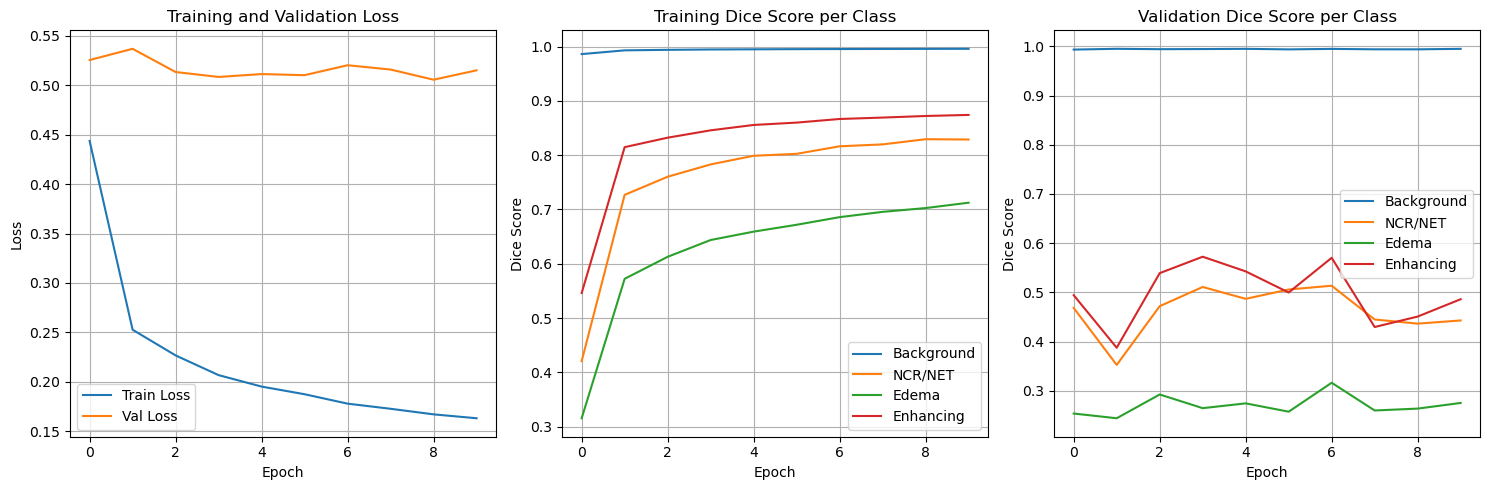

In [9]:
# NEW FOR MODEL 4: Visualize training progress with per-class Dice scores
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Training Dice per class
plt.subplot(1, 3, 2)
train_dice_array = np.array(history['train_dice_per_class'])
for c, label in enumerate(['Background', 'NCR/NET', 'Edema', 'Enhancing']):
    plt.plot(train_dice_array[:, c], label=label)
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Training Dice Score per Class')
plt.legend()
plt.grid(True)

# Validation Dice per class
plt.subplot(1, 3, 3)
val_dice_array = np.array(history['val_dice_per_class'])
for c, label in enumerate(['Background', 'NCR/NET', 'Edema', 'Enhancing']):
    plt.plot(val_dice_array[:, c], label=label)
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Validation Dice Score per Class')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Validation & Visualization

In [10]:
# Load the trained model
testModel = SimpleUNet(num_classes=4)
testModel.load_state_dict(torch.load('model4_checkpoint.pth', weights_only=True))
testModel = testModel.to(device)
testModel.eval()

SimpleUNet(
  (enc1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

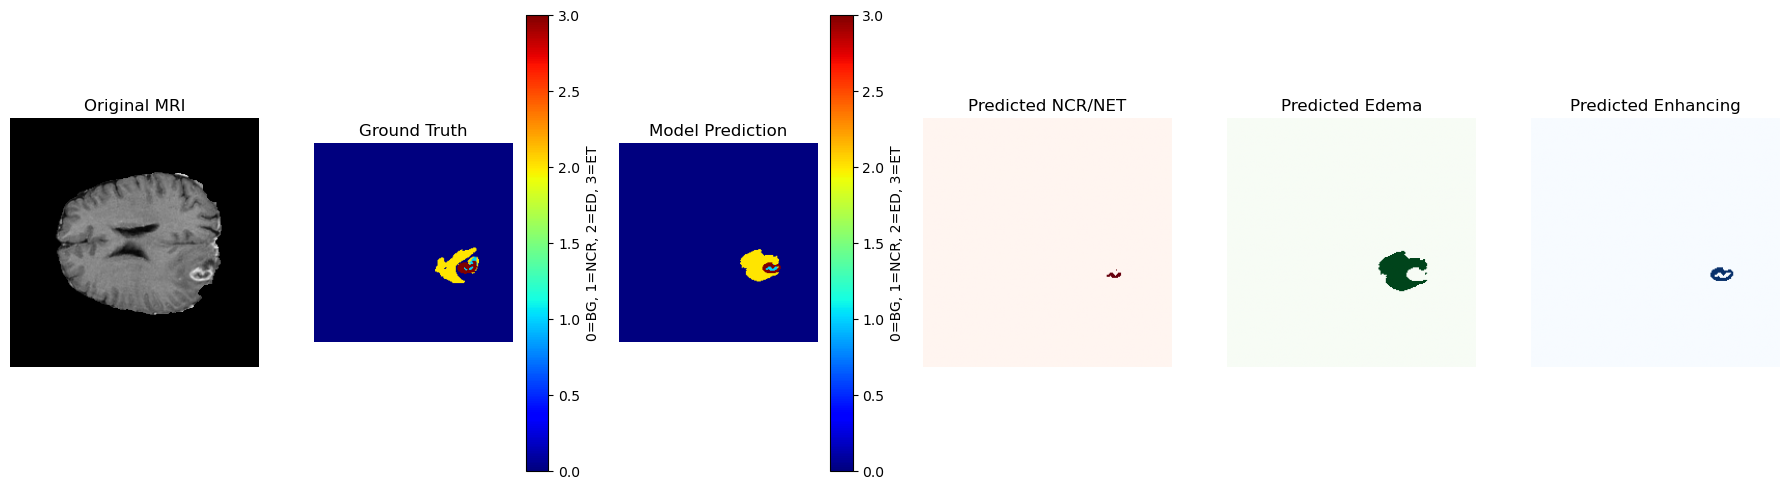

In [11]:
# Test on a sample from validation set
test_img, test_mask = validation_dataset[220] 

input_tensor = test_img.unsqueeze(0).to(device)

with torch.no_grad(): 
    prediction = testModel(input_tensor)
    # NEW: Apply softmax and get class predictions
    prediction_probs = torch.softmax(prediction, dim=1)
    prediction_classes = torch.argmax(prediction_probs, dim=1)

pred_cpu = prediction_classes.squeeze().cpu().numpy()
img_cpu = test_img.squeeze().numpy()
mask_cpu = test_mask.numpy()

plt.figure(figsize=(18, 5))

plt.subplot(1, 6, 1)
plt.imshow(img_cpu, cmap='gray')
plt.title("Original MRI")
plt.axis('off')

plt.subplot(1, 6, 2)
plt.imshow(mask_cpu, cmap='jet', vmin=0, vmax=3)
plt.title("Ground Truth")
plt.colorbar(label="0=BG, 1=NCR, 2=ED, 3=ET")
plt.axis('off')

plt.subplot(1, 6, 3)
plt.imshow(pred_cpu, cmap='jet', vmin=0, vmax=3)
plt.title("Model Prediction")
plt.colorbar(label="0=BG, 1=NCR, 2=ED, 3=ET")
plt.axis('off')

# Show each predicted class separately
plt.subplot(1, 6, 4)
plt.imshow((pred_cpu == 1).astype(float), cmap='Reds')
plt.title("Predicted NCR/NET")
plt.axis('off')

plt.subplot(1, 6, 5)
plt.imshow((pred_cpu == 2).astype(float), cmap='Greens')
plt.title("Predicted Edema")
plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow((pred_cpu == 3).astype(float), cmap='Blues')
plt.title("Predicted Enhancing")
plt.axis('off')

plt.tight_layout()
plt.show()

# Next Steps for Model 5:

**Primary Goal: Multi-Modality Input**
- Incorporate all 4 MRI modalities (T1, T1ce, T2, FLAIR)
- Modify model input from 1 channel to 4 channels
- Each modality provides unique information about the tumor


**Action Items**


- NEXT (Multi-modality 2D U-Net):

Increase batch size to 32-64
Add mixed precision training
Expected time: 1-1.5 hours for 4 modalities

- FUTURE (3D U-Net):

Use ml.p3.2xlarge instance (V100 GPU)
Implement patch-based training
Use gradient checkpointing
Consider multi-GPU if needed
Expected time: 2-3 hours for full 3D trainin

**Additional Improvements:**
- Better data preprocessing (intensity normalization across modalities)
- More sophisticated augmentation (elastic deformation, intensity shifts)
- Evaluation using BraTS regions (WT, TC, ET) not just raw labels

**Still for Future (Model 6+):**
- 3D U-Net architecture
- Patch-based training
- Ensemble methods